# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

----

<a id='start'></a>
# Содержание



## Подготовка данных
   * <a href='#step_1'> Загружаем библиотеки </a>
   * <a href='#step_1'> Откроем файл и изучим его </a>
          - Путь к файлу: (/datasets/autos.csv)
   * <a href='#step_1.1'> Просмотим зависимотсть целевого значения от других признаков в наших данных на гарфике </a>
   * <a href='#step_1.1.1'>Применим кодирование текстовых данных в категориальные цифровые значения методом `OrdinalEncoder`</a>
   * <a href='#step_1.2'> Разделим данные на тренировочную выборку и целевой признак </a>
   * <a href='#step_1.3'> Применим масштабирование к нашим данным при помощи `StandardScaler`</a>
   * <a href='#step_1.end'> Вывод </a>

## Обучение моделей
   * <a href='#step_2.1'> Создадим функцию для подсчёта $RMSE$ </a>
   * <a href='#step_2.1'> Создадим функцию, которая будет принимать на вход целевые и предсказанные значения, а возвращать абсолютное и среднеквадратичное отклонение на графиках с визульным распределением разброса целевых признаков </a>
   * <a href='#step_2.1'> LinearRegression </a>
   * <a href='#step_2.2'>RandomForestRegressor</a>
   * <a href='#step_2.3'> CatBoostRegressor </a>
   * <a href='#step_2.4'> LightGBM  </a>
  
   * <a href='#step_2.end'> Вывод </a>   
   
   
## Анализ моделей
   * <a href='#step_3'>Проанализируем скорость работы и качество моделей и занесём данные в сводную таблицу </a>
   * <a href='#step_3.2'>Проведём анализ остатков предсказаний моделей и определим что и как модель чаще всего хорошо/плохо предсказывает</a>
   * <a href='#step_3.3'>Вывод</a>
   
## Общий вывод   
   * <a href='#step_3.end'> Вывод </a>
   


**Признаки**
- `Daterawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)

## Загружаем библиотеки

In [1]:
!pip install category_encoders optuna

In [2]:
import pandas as pd
import numpy as np
import optuna

from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
import lightgbm as lgbm
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import time

Обозначим константы:

In [3]:
RANDOM_STATE = 42

<a id="step_1"></a>
## Подготовка данных

### Откроем файлы и изучим их

In [4]:
data =  pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Приведём столбцы с датой к формату `datetime64`

In [6]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')

In [7]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Посмотрим на целевой столбец *Price* с ценой автомобилей

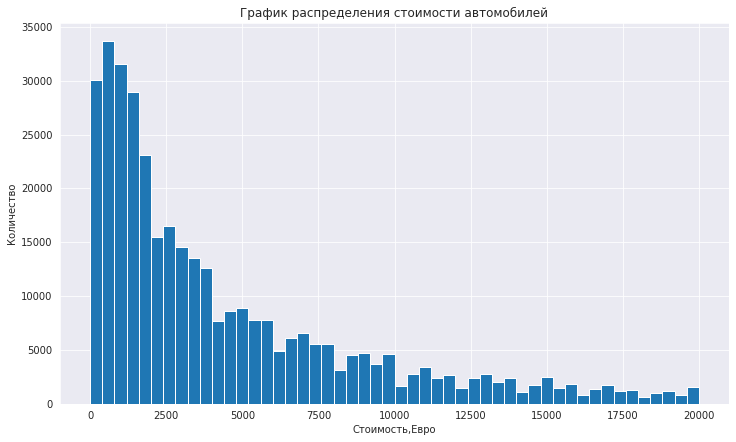

In [8]:
sns.set_style('darkgrid')
data.Price.hist(bins=50,figsize=(12,7))
plt.title('График распределения стоимости автомобилей')
plt.xlabel('Стоимость,Евро')
plt.ylabel('Количество')
plt.show()

In [9]:
data.loc[data['Price'] < 10]['Price'].count()

12028

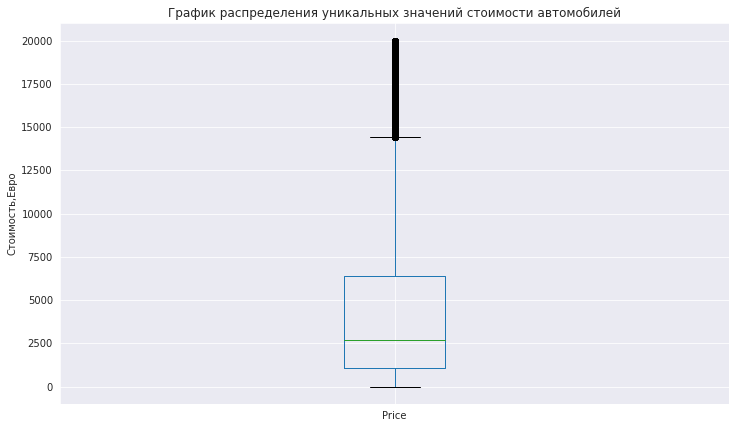

In [10]:
data.boxplot(['Price'],figsize=(12,7))
plt.title('График распределения уникальных значений стоимости автомобилей')

plt.ylabel('Стоимость,Евро')
plt.show()

##### Удалим данные стоимости автомобилей ниже *10€*, т.к. такие значения нам не интересны. Владельцы а/м могут указывать такую цену только за разбитый а/м под восставновление, либо с расчётом на равноценный обмен.

In [11]:
data = data.query('Price> 10')

In [12]:
data.loc[data['Price'] < 10]['Price'].count()

0

### Посмотрим на отсутствующие значения колонки "VehicleType" и заполним их значением N/A

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342257 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        342257 non-null  datetime64[ns]
 1   Price              342257 non-null  int64         
 2   VehicleType        309055 non-null  object        
 3   RegistrationYear   342257 non-null  int64         
 4   Gearbox            325355 non-null  object        
 5   Power              342257 non-null  int64         
 6   Model              325026 non-null  object        
 7   Kilometer          342257 non-null  int64         
 8   RegistrationMonth  342257 non-null  int64         
 9   FuelType           313315 non-null  object        
 10  Brand              342257 non-null  object        
 11  Repaired           277131 non-null  object        
 12  DateCreated        342257 non-null  datetime64[ns]
 13  NumberOfPictures   342257 non-null  int64   

In [14]:
data['VehicleType']=data['VehicleType'].fillna('N/A')

#### Проверим результат

In [15]:
data.VehicleType.isna().sum()

0

### Проверим столбец "RegistrationYear" на уникальные значения

In [16]:
data.RegistrationYear.unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 5000, 1958, 1967, 1956, 3200,
       1000, 1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940,
       3000, 2066, 1949, 2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 1400, 1950, 4000, 1948,
       1952, 8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933,
       1936, 1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934,
       1928, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931, 4500,
       1602, 7800, 1947, 1927, 7100, 8200, 1946])

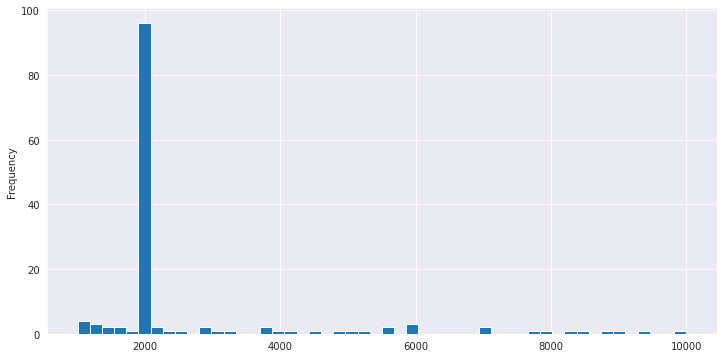

In [17]:
pd.Series(list(data.RegistrationYear.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.show()

### Вычислим дату формирования списков а/м и отсортируем данные о регистрации по этой дате, а так же удалим совсем старые а/м, которым более 67 лет.

In [18]:
data.DateCrawled.max()

Timestamp('2016-04-07 14:36:58')

In [19]:
data=data.query('RegistrationYear >= 1950 & RegistrationYear < 2017')

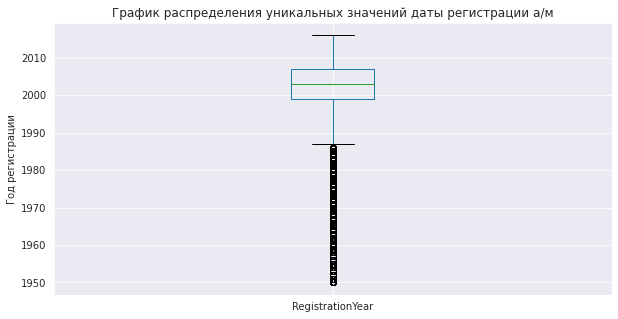

In [20]:
data.boxplot('RegistrationYear', figsize=(10,5))
plt.title('График распределения уникальных значений даты регистрации а/м')
plt.ylabel('Год регистрации')
plt.xlabel('')
plt.show()

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328385 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        328385 non-null  datetime64[ns]
 1   Price              328385 non-null  int64         
 2   VehicleType        328385 non-null  object        
 3   RegistrationYear   328385 non-null  int64         
 4   Gearbox            313265 non-null  object        
 5   Power              328385 non-null  int64         
 6   Model              313070 non-null  object        
 7   Kilometer          328385 non-null  int64         
 8   RegistrationMonth  328385 non-null  int64         
 9   FuelType           304746 non-null  object        
 10  Brand              328385 non-null  object        
 11  Repaired           269271 non-null  object        
 12  DateCreated        328385 non-null  datetime64[ns]
 13  NumberOfPictures   328385 non-null  int64   

### Посмотрим на отсутствующие данные по столбцу "Gearbox"

In [22]:
data.query('Gearbox.isna()')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
16,2016-04-01 12:46:46,300,N/A,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,N/A,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01,0,47249,2016-04-07 08:46:07
92,2016-03-16 07:56:19,250,N/A,2000,NaN,60,ka,150000,0,NaN,ford,NaN,2016-03-16,0,51427,2016-03-21 09:47:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,2016-03-16 13:36:25,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,2016-03-16,0,12057,2016-03-17 12:17:07
354305,2016-04-03 13:46:24,3500,N/A,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03,0,74579,2016-04-05 12:44:38
354329,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30,0,25436,2016-04-07 13:50:41
354338,2016-03-31 19:52:33,180,N/A,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31,0,41470,2016-04-06 14:18:04


In [23]:
data.Gearbox.unique()

array(['manual', 'auto', nan], dtype=object)

##### Информация о корбкe передач достаточно важный параметр, который сильно может повлиять на модель при обучении, но 15120 значений это достаточно много для удаления. В связи с этим лучше  заполнить пропуски каким-то значением. 

In [24]:
data['Gearbox']=data['Gearbox'].fillna('N/A')

##### Проверим результат

In [25]:
data.Gearbox.unique()

array(['manual', 'auto', 'N/A'], dtype=object)

### Посмотрим на значения в столбце "Power"

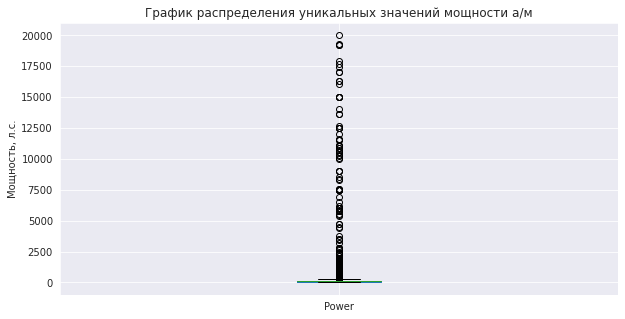

In [26]:
data.boxplot('Power', figsize=(10,5))
plt.title('График распределения уникальных значений мощности а/м')
plt.ylabel('Мощность, л.с.')
plt.xlabel('')
plt.show()

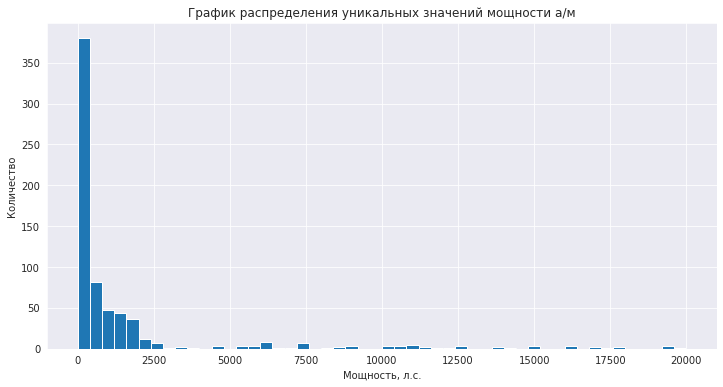

In [27]:
pd.Series(list(data.Power.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.title('График распределения уникальных значений мощности а/м')
plt.ylabel('Количество')
plt.xlabel('Мощность, л.с.')
plt.show()

##### Очевидно, что таких мощностей не бывает и такие данные так же требуется удалить из  нашей базы данных.

In [28]:
data.Power.describe()

count    328385.000000
mean        112.077327
std         185.054794
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

#####  Удалим данные о мощности дигателя свыше 2500 л.с. и менее 15 л.с.

In [29]:
data = data.query('Power < 1000')

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328123 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        328123 non-null  datetime64[ns]
 1   Price              328123 non-null  int64         
 2   VehicleType        328123 non-null  object        
 3   RegistrationYear   328123 non-null  int64         
 4   Gearbox            328123 non-null  object        
 5   Power              328123 non-null  int64         
 6   Model              312835 non-null  object        
 7   Kilometer          328123 non-null  int64         
 8   RegistrationMonth  328123 non-null  int64         
 9   FuelType           304524 non-null  object        
 10  Brand              328123 non-null  object        
 11  Repaired           269103 non-null  object        
 12  DateCreated        328123 non-null  datetime64[ns]
 13  NumberOfPictures   328123 non-null  int64   

### Просмотрим пропущенные значения по столбцу "Model"

In [31]:
data.query('Model.isna()')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03,0,45665,2016-04-05 11:47:13
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27,0,38709,2016-04-05 20:17:31
151,2016-03-27 20:47:22,6799,small,2009,N/A,60,NaN,20000,5,petrol,volkswagen,no,2016-03-27,0,89077,2016-03-27 20:47:22
160,2016-03-19 19:49:15,500,small,1999,manual,0,NaN,150000,0,petrol,renault,no,2016-03-19,0,26969,2016-04-01 11:17:48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354245,2016-03-07 16:37:42,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,2016-03-07,0,55743,2016-03-12 21:45:25
354321,2016-03-15 13:52:34,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,yes,2016-03-15,0,91186,2016-03-17 08:16:25
354338,2016-03-31 19:52:33,180,N/A,1995,N/A,0,NaN,125000,3,petrol,opel,NaN,2016-03-31,0,41470,2016-04-06 14:18:04
354351,2016-03-11 23:40:32,1900,N/A,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11,0,87700,2016-03-12 14:16:51


##### Модель - это важный фактор, влияющий на образование цены, но без знания модели остальные характеристика автомобиля могут предсказать и модель, неважно указана она или нет, ведь у моделей похожие характеристики, оставим данные без потерь.

In [32]:
data['Model']=data['Model'].fillna('N/A')

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328123 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        328123 non-null  datetime64[ns]
 1   Price              328123 non-null  int64         
 2   VehicleType        328123 non-null  object        
 3   RegistrationYear   328123 non-null  int64         
 4   Gearbox            328123 non-null  object        
 5   Power              328123 non-null  int64         
 6   Model              328123 non-null  object        
 7   Kilometer          328123 non-null  int64         
 8   RegistrationMonth  328123 non-null  int64         
 9   FuelType           304524 non-null  object        
 10  Brand              328123 non-null  object        
 11  Repaired           269103 non-null  object        
 12  DateCreated        328123 non-null  datetime64[ns]
 13  NumberOfPictures   328123 non-null  int64   

###  Посмотрим на данные о пробеге а/м в столбце "Kilometer"

In [34]:
data.Kilometer.describe()

count    328123.000000
mean     128287.639087
std       37375.809857
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

##### Данный столбец не требует изменений, здесь всё Ок.

###  Посмотрим на значения в столбце "RegistrationMonth"

In [35]:
data.RegistrationMonth.describe()

count    328123.000000
mean          5.830183
std           3.674648
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

In [36]:
data.RegistrationMonth.unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

In [37]:
data.RegistrationMonth.value_counts()

3     32605
6     29659
0     28797
4     27576
5     27472
7     25706
10    24749
11    22938
12    22833
9     22605
1     21821
8     21308
2     20054
Name: RegistrationMonth, dtype: int64

##### Т.к. этот параметр не имеет особого значения на ценообразование, а терять данные нам не хочется, заменим нулевые значения на среднее значение

In [38]:
data.loc[data['RegistrationMonth'] == 0,'RegistrationMonth'] =6

##### Проверяем результат

In [39]:
data.loc[data['RegistrationMonth'] == 6].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,N/A,1993,manual,0,golf,150000,6,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,6,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06
16,2016-04-01 12:46:46,300,N/A,2016,N/A,60,polo,150000,6,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
18,2016-03-23 15:48:05,7550,bus,2007,manual,136,c_max,150000,6,gasoline,ford,no,2016-03-23,0,88361,2016-04-05 18:45:11


In [40]:
data.RegistrationMonth.unique()

array([ 6,  5,  8,  7, 10, 12, 11,  2,  3,  1,  4,  9])

### Посмотроим на значения в столбце "FuelType"

In [41]:
data.FuelType.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [42]:
data.FuelType.value_counts()

petrol      203917
gasoline     94610
lpg           5009
cng            528
hybrid         219
other          155
electric        86
Name: FuelType, dtype: int64

In [43]:
data.FuelType.isna().sum()

23599

##### Заполним отсутствующие значения как "other"

In [44]:
data['FuelType']=data['FuelType'].fillna('other')

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328123 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        328123 non-null  datetime64[ns]
 1   Price              328123 non-null  int64         
 2   VehicleType        328123 non-null  object        
 3   RegistrationYear   328123 non-null  int64         
 4   Gearbox            328123 non-null  object        
 5   Power              328123 non-null  int64         
 6   Model              328123 non-null  object        
 7   Kilometer          328123 non-null  int64         
 8   RegistrationMonth  328123 non-null  int64         
 9   FuelType           328123 non-null  object        
 10  Brand              328123 non-null  object        
 11  Repaired           269103 non-null  object        
 12  DateCreated        328123 non-null  datetime64[ns]
 13  NumberOfPictures   328123 non-null  int64   

In [46]:
data.Brand.unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia', 'citroen',
       'sonstige_autos', 'toyota', 'chevrolet', 'dacia', 'daihatsu',
       'trabant', 'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche',
       'saab', 'land_rover', 'lada'], dtype=object)

##### Отлично, здесь ничего дополнять или удалять не требуется

### Посмотрим на значения  в столбце "Repaired"     

In [47]:
data.Repaired.unique()

array([nan, 'yes', 'no'], dtype=object)

In [48]:
data.Repaired.isna().sum()

59020

##### Очевидно, что эти данные лучше заполнить N/A, чем потерять 39000 строк остального массива данных

In [49]:
data['Repaired']=data['Repaired'].fillna('N/A')

##### Проверяем

In [50]:
data.Repaired.unique()

array(['N/A', 'yes', 'no'], dtype=object)

### Посмотрим на значения  в столбце "DateCreated"     

In [51]:
data.DateCreated.describe()

count                  328123
unique                    108
top       2016-04-03 00:00:00
freq                    12790
first     2014-03-10 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

### Посмотрим на значения  в столбце "NumberOfPictures"     

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328123 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        328123 non-null  datetime64[ns]
 1   Price              328123 non-null  int64         
 2   VehicleType        328123 non-null  object        
 3   RegistrationYear   328123 non-null  int64         
 4   Gearbox            328123 non-null  object        
 5   Power              328123 non-null  int64         
 6   Model              328123 non-null  object        
 7   Kilometer          328123 non-null  int64         
 8   RegistrationMonth  328123 non-null  int64         
 9   FuelType           328123 non-null  object        
 10  Brand              328123 non-null  object        
 11  Repaired           328123 non-null  object        
 12  DateCreated        328123 non-null  datetime64[ns]
 13  NumberOfPictures   328123 non-null  int64   

In [53]:
data.NumberOfPictures.describe()

count    328123.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

##### В данном столбце нет никакой пользы для обучения модели, т.к. кроме нулей здесь значений нет. Такой столбец лучше так же исключить из списка 

In [54]:
data=data.drop(['NumberOfPictures'], axis=1)

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328123 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        328123 non-null  datetime64[ns]
 1   Price              328123 non-null  int64         
 2   VehicleType        328123 non-null  object        
 3   RegistrationYear   328123 non-null  int64         
 4   Gearbox            328123 non-null  object        
 5   Power              328123 non-null  int64         
 6   Model              328123 non-null  object        
 7   Kilometer          328123 non-null  int64         
 8   RegistrationMonth  328123 non-null  int64         
 9   FuelType           328123 non-null  object        
 10  Brand              328123 non-null  object        
 11  Repaired           328123 non-null  object        
 12  DateCreated        328123 non-null  datetime64[ns]
 13  PostalCode         328123 non-null  int64   

### Посмотрим на значения  в столбце "PostalCode"

In [56]:
data.PostalCode.describe()

count    328123.000000
mean      50791.343816
std       25765.284676
min        1067.000000
25%       30457.000000
50%       49632.000000
75%       71364.000000
max       99998.000000
Name: PostalCode, dtype: float64

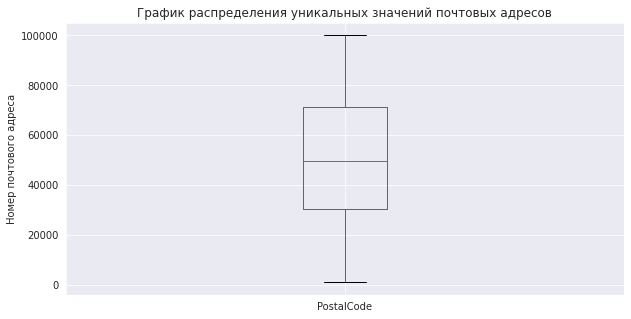

In [57]:
data.boxplot('PostalCode', figsize=(10,5))
plt.title('График распределения уникальных значений почтовых адресов')
plt.ylabel('Номер почтового адреса')
plt.xlabel('')
plt.show()

##### Распределение почтовых номеров говорит нам о том, что здесь нет необходимости что-либо корректировать, а  сохранять такие данные следует только с целью вычисления географической принадлежности а/м. В нашем случае, чтобы избежать большого количества категорий оставим от индекса только первую цифру

In [58]:
data["PostalCode"]=data["PostalCode"].astype('str')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328123 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        328123 non-null  datetime64[ns]
 1   Price              328123 non-null  int64         
 2   VehicleType        328123 non-null  object        
 3   RegistrationYear   328123 non-null  int64         
 4   Gearbox            328123 non-null  object        
 5   Power              328123 non-null  int64         
 6   Model              328123 non-null  object        
 7   Kilometer          328123 non-null  int64         
 8   RegistrationMonth  328123 non-null  int64         
 9   FuelType           328123 non-null  object        
 10  Brand              328123 non-null  object        
 11  Repaired           328123 non-null  object        
 12  DateCreated        328123 non-null  datetime64[ns]
 13  PostalCode         328123 non-null  object  

In [59]:
first_index = []
for word in np.array(data['PostalCode']):
    case_word = word[0]
    first_index.append(case_word)
data["GeogrphyIndex"]=first_index
data["GeogrphyIndex"]=data["GeogrphyIndex"].astype('int')

##### Провермим результат

In [60]:
data.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen,GeogrphyIndex
0,2016-03-24 11:52:17,480,N/A,1993,manual,0,golf,150000,6,petrol,volkswagen,N/A,2016-03-24,70435,2016-04-07 03:16:57,7
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,N/A,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50,6


### Посмотрим на значения  в столбце "LastSeen"

In [61]:
data.LastSeen.describe()

count                  328123
unique                 168163
top       2016-04-06 09:46:00
freq                       16
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: LastSeen, dtype: object

### Посмотрим коррелирущие значения  после предобработки данных

In [62]:
data\
    .corr()\
    .style\
    .background_gradient(cmap='coolwarm')

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,GeogrphyIndex
Price,1.000000,0.450147,0.487280,-0.358196,0.017003,0.065510
RegistrationYear,0.450147,1.000000,0.150988,-0.235913,0.014515,0.021771
Power,0.487280,0.150988,1.000000,0.078978,0.019040,0.069013
Kilometer,-0.358196,-0.235913,0.078978,1.000000,0.008479,-0.016502
RegistrationMonth,0.017003,0.014515,0.019040,0.008479,1.000000,-0.008469
GeogrphyIndex,0.065510,0.021771,0.069013,-0.016502,-0.008469,1.000000


##### Наблюдается сильная положительная корреляция стоимости от мощности и года регитстрации а/м, в то время как пробег имеет сильную отрицательную зависмость и так же сказывается на ценообразовании подержанного автомобиля

<a id="step_1.1"></a>
### Просмотим зависимотсть целевого значения от других признаков в наших данных на гарфике

In [63]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'PostalCode', 'LastSeen', 'GeogrphyIndex'],
      dtype='object')

In [64]:
column=['Price', 'RegistrationYear',
       'Power', 'Kilometer','FuelType']

In [65]:
data_graph=data[column]
data_graph[:5]

,Price,RegistrationYear,Power,Kilometer,FuelType
0,480,1993,0,150000,petrol
1,18300,2011,190,125000,gasoline
2,9800,2004,163,125000,gasoline
3,1500,2001,75,150000,petrol
4,3600,2008,69,90000,gasoline


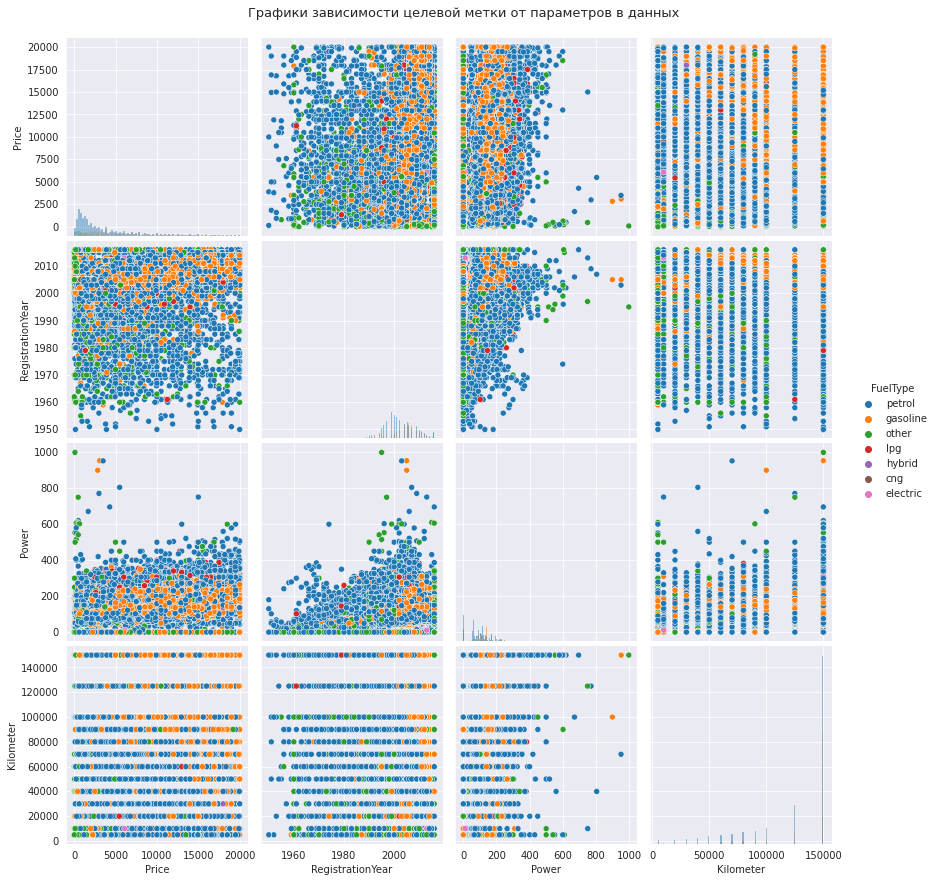

In [66]:
sns.pairplot(data_graph[:100000], hue='FuelType', height=3, diag_kind='hist')
plt.suptitle("Графики зависимости целевой метки от параметров в данных", y=1.02, fontsize=13)
plt.show()

##### Судя  по графику можно сказать, что начиная с 1980 года стоимосоть а/м увеличивается с каждым годом и имеет линейную зависимость, при этом не важен тип используемого топлива. Так же из графиков хорошо видно, что альтернативные виды топлива начали активно использоваться в автомобилях начиная с 2000 годов в то время как бензиновые двигателя начали отходить на второй план

<a id="step_1.1.1"></a>
## Применим кодирование текстовых данных в категориальные цифровые значения методом `OrdinalEncoder`

##### Для начала выберем действительно значимые столбцы, которые могут иметьзначения в  ценообразовании стоимости подержанных автомоблилей, а лишние значения мы опустим, чтобы не "зашумлять" вычисления моделей


In [67]:
data.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen,GeogrphyIndex
0,2016-03-24 11:52:17,480,N/A,1993,manual,0,golf,150000,6,petrol,volkswagen,N/A,2016-03-24,70435,2016-04-07 03:16:57,7
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,N/A,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50,6


In [68]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'PostalCode', 'LastSeen', 'GeogrphyIndex'],
      dtype='object')

In [69]:
columns=['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired','GeogrphyIndex']

##### Запишем данные с интересующими нас столбцами в новый Data Frame

In [70]:
data_for_model = data[columns].copy()
data_for_model.head(2)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,GeogrphyIndex
0,480,N/A,1993,manual,0,golf,150000,6,petrol,volkswagen,N/A,7
1,18300,coupe,2011,manual,190,N/A,125000,5,gasoline,audi,yes,6


In [71]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328123 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              328123 non-null  int64 
 1   VehicleType        328123 non-null  object
 2   RegistrationYear   328123 non-null  int64 
 3   Gearbox            328123 non-null  object
 4   Power              328123 non-null  int64 
 5   Model              328123 non-null  object
 6   Kilometer          328123 non-null  int64 
 7   RegistrationMonth  328123 non-null  int64 
 8   FuelType           328123 non-null  object
 9   Brand              328123 non-null  object
 10  Repaired           328123 non-null  object
 11  GeogrphyIndex      328123 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 32.5+ MB


In [72]:
# КОД РЕВЬЮЕРА
data_for_model.duplicated().sum()

22289

In [73]:
data_for_model = data_for_model.drop_duplicates() 

In [74]:
data_for_model.duplicated().sum()

0

In [75]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305834 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              305834 non-null  int64 
 1   VehicleType        305834 non-null  object
 2   RegistrationYear   305834 non-null  int64 
 3   Gearbox            305834 non-null  object
 4   Power              305834 non-null  int64 
 5   Model              305834 non-null  object
 6   Kilometer          305834 non-null  int64 
 7   RegistrationMonth  305834 non-null  int64 
 8   FuelType           305834 non-null  object
 9   Brand              305834 non-null  object
 10  Repaired           305834 non-null  object
 11  GeogrphyIndex      305834 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 30.3+ MB


##### Сбросим индексы, после удаления лишних значений

In [76]:
data_for_model=data_for_model.reset_index(drop=True)

In [77]:
data_for_model

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,GeogrphyIndex
0,480,N/A,1993,manual,0,golf,150000,6,petrol,volkswagen,N/A,7
1,18300,coupe,2011,manual,190,N/A,125000,5,gasoline,audi,yes,6
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,N/A,9
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,9
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,6
...,...,...,...,...,...,...,...,...,...,...,...,...
305829,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,9
305830,2200,N/A,2005,N/A,0,N/A,20000,1,other,sonstige_autos,N/A,3
305831,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2
305832,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,8


<a id="step_1.2"></a>
## Разделим данные на основную выборку и целевые признаки

In [78]:
features=data_for_model.drop(['Price'],axis=1)
target=data_for_model['Price']

In [79]:
features.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired',
       'GeogrphyIndex'],
      dtype='object')

In [80]:
features.head(1)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,GeogrphyIndex
0,N/A,1993,manual,0,golf,150000,6,petrol,volkswagen,N/A,7


##### Выберем только категориальные признаки

In [81]:
train_features, test_features, train_target, test_target = train_test_split(features,target, \
                                                                            test_size=0.25, \
                                                                            random_state=RANDOM_STATE)

In [82]:
col=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


encoder = OrdinalEncoder()
encoder.fit(train_features[col])

train_features[col]=encoder.transform(train_features[col])
test_features[col]=encoder.transform(test_features[col])

#features_ord=features.copy()
#features_ord[col]= pd.DataFrame(encoder.transform(features[col]), columns = features[col].columns)

print(train_features.shape)
print(test_features.shape)

train_features.head()

(229375, 11)
(76459, 11)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,GeogrphyIndex
117530,8.0,2004,1.0,204,96.0,150000,9,2.0,20.0,0.0,2
242321,3.0,2004,2.0,231,191.0,80000,6,6.0,19.0,2.0,6
105651,5.0,1997,2.0,90,117.0,150000,3,6.0,38.0,2.0,8
233141,1.0,2003,2.0,101,93.0,150000,5,2.0,9.0,1.0,3
137560,8.0,1998,1.0,102,167.0,150000,5,2.0,20.0,1.0,3


##### Проверим результат

In [83]:
#features.head()

### Определим тестовую и тренировочну выбрку

In [84]:
#train_features, test_features, train_target, test_target = train_test_split(features_ord,target, \
                                                                            #test_size=0.4, \
                                                                            #random_state=RANDOM_STATE)

### Проверим результат

In [85]:
train_sample=train_features.shape[0]/features.shape[0]
test_sample=test_target.shape[0]/target.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки- 75%
Размер тестовой выборки - 25%


<a id="step_1.3"></a>
## Применим масштабирование к нашим данным при помощи `StandardScaler`

In [86]:
numeric=['VehicleType','RegistrationYear','Gearbox','Power','Model','Kilometer','FuelType','Brand','Repaired']


scaler=StandardScaler()
scaler.fit(train_features[numeric])


train_features[numeric]=scaler.transform(train_features[numeric])
test_features[numeric]=scaler.transform(test_features[numeric])


print(train_features.shape)
print(test_features.shape)

train_features.head()

(229375, 11)
(76459, 11)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,GeogrphyIndex
117530,1.272725,0.209049,-1.316517,1.511131,-0.137805,0.579000,9,-1.539000,-0.060863,-1.739703,2
242321,-0.807897,0.209049,0.520499,1.937804,1.193422,-1.292861,6,0.704929,-0.136190,2.046853,6
105651,0.024352,-0.822592,0.520499,-0.290377,0.156467,0.579000,3,0.704929,1.295022,2.046853,8
233141,-1.640146,0.061671,0.520499,-0.116548,-0.179843,0.579000,5,-1.539000,-0.889459,0.153575,3
137560,1.272725,-0.675215,-1.316517,-0.100745,0.857112,0.579000,5,-1.539000,-0.060863,0.153575,3


<a id="step_1.end"></a>
## Вывод

Из даных убраны лишние и "битые" значения, текстовые признаки трансформированы в цифровой формат, а так же выборки  разделены на тренировочную и тестовую для проверки качества предсказания моделей. Теперь перейдём к обучению моделей и выбору лучшей. А так же оценим их качество предсказания и скорость обучения.

In [88]:
print('Процент потери данных:', 100 - (100 * 305834 /354369))

Процент потери данных: 13.696175455527992


<a href='#start'>Вернуться к оглавлению</a>
<a id="step_2"></a>
## Обучение моделей

<font ><b> Обучим разные модели. Для каждой укажем оптимальные гиперпараметры и поставим счётчик времени выполнения операций.


### Для расчёта целевой метрики используем RMSE и напишем функцию.

In [89]:
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

### Создадим функцию, которая будет принимать на вход целевые и предсказанные значения, а возвращать абсолютное и среднеквадратичное отклонение на графиках с визульным распределением разброса целевых признаков 

In [90]:
def illustration_target(test,predict):
    rmse= mean_squared_error(test,predict)
    mae=mean_absolute_error(test,predict)
    plt.figure(figsize=(8, 5))
    pd.Series(predict).hist(bins=20, alpha=0.8)
    pd.Series(test).hist(bins=20, alpha=0.8)
    plt.text(16122,11225,'MAE={:.2f}'.format(mae))
    plt.text(16122,10225,'RMSE={:.2f}'.format(rmse**0.5))
    plt.legend(['Предсказанные значения', 'Истинные значения'])
    plt.title('График распределения предсказанных и истинных значениий', y=1.05)
    plt.xlabel('Предсказанные / Истинные значения')
    plt.ylabel('Количество')
    plt.subplot()
    
    plt.figure(figsize=(8, 8))
    plt.plot(predict,test,'o', alpha=0.5)
    plt.xlim(-5000,25000)
    plt.ylim(-5000,25000)
    plt.plot([-10000,25000],[-10000,25000],'--y', linewidth=2)
    #plt.text(25222,11225,'MAE={:.2f}'.format(mae))
    #plt.text(25222,10225,'RMSE={:.2f}'.format(rmse**0.5))
    plt.title('График отношения предсказанных значений к истинным значениям', y=1.05)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show()

### Для понимания, какие факторы важны при моделировании, создадим функцию, используя <br><br>`feature_importances_ `

In [91]:
def importances(model,features):
    features=features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(11, 5))
    plt.title('Важность функции')
    plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Относительная важность')
    plt.show()
        
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    feat_importances = feat_importances.to_frame()
    feat_importances.columns=['Относительная важность']
    display(feat_importances)

#### Поделим тестовую выборку на тестовую и валидационную

In [92]:
test_features, valid_features, test_target, valid_target = train_test_split(test_features,\
                                                                              test_target,
                                                                              test_size=0.5, 
                                                                              random_state=RANDOM_STATE)

print('test_features: ', test_features.shape)
print('valid_features: ', valid_features.shape)


test_features:  (38229, 11)
valid_features:  (38230, 11)


<a id="step_2.1"></a>
### LinearRegression

In [93]:
%%time
start = time.time()
model_lr=LinearRegression(normalize=True)
model_lr.fit(train_features,train_target)
end = time.time()
t_lr=round(end-start,2)

CPU times: user 95.9 ms, sys: 23.9 ms, total: 120 ms
Wall time: 115 ms


In [94]:
%%time
start = time.time()
predict_lr=model_lr.predict(valid_features)
end = time.time()
t_lr_p=round(end-start,2)

CPU times: user 7.18 ms, sys: 8.1 ms, total: 15.3 ms
Wall time: 4.35 ms


In [95]:
print(' Гиперпараметры модели:\n',model_lr)

 Гиперпараметры модели:
 LinearRegression(normalize=True)


In [96]:
mae_lr=mean_absolute_error(valid_target, predict_lr)
print('MAE модели Линейная Регрессия равна:',mae_lr.round(2))
rmse_lr=rmse(valid_target, predict_lr)
print('RMSE модели Линейная Регрессия равна:', rmse_lr)

MAE модели Линейная Регрессия равна: 2243.37
RMSE модели Линейная Регрессия равна: 3158.23


#### Показатели предсказания модели `LinearRegression`

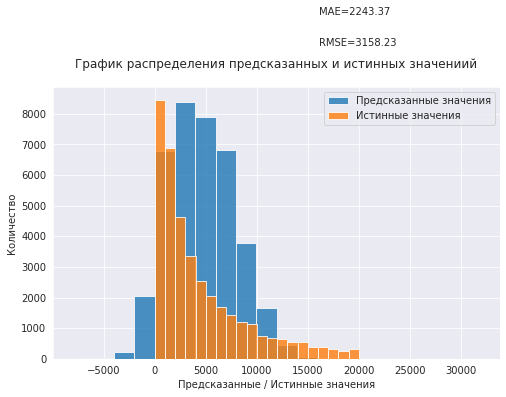

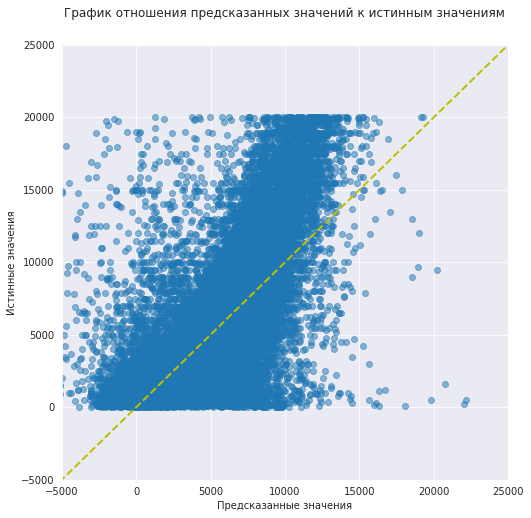

In [97]:
illustration_target(valid_target, predict_lr)

#### Факторы важности модели `LinearRegression` 

##### К сожалению для модели `LinearRegression` Факторы важности отсутствуют, т.к. модель проста и не располагает ветвлением деревьев

<a id="step_2.2"></a>
### RandomForestRegressor

In [98]:
%%time
start = time.time()
model_rf = RandomForestRegressor(random_state=RANDOM_STATE, criterion='mse',warm_start=False, n_estimators=100)
model_rf.fit(train_features, train_target)
end = time.time()
t_rf=round(end-start,2)

CPU times: user 1min 39s, sys: 1.37 s, total: 1min 40s
Wall time: 1min 40s


In [99]:
print(' Гиперпараметры модели:\n',model_rf)

 Гиперпараметры модели:
 RandomForestRegressor(random_state=42)


In [100]:
%%time
start = time.time()
pred_rf=model_rf.predict(valid_features)
end = time.time()
t_rf_p=round(end-start,2)

CPU times: user 2.73 s, sys: 8 ms, total: 2.74 s
Wall time: 2.75 s


#### Показатели предсказания модели `RandomForestRegressor`

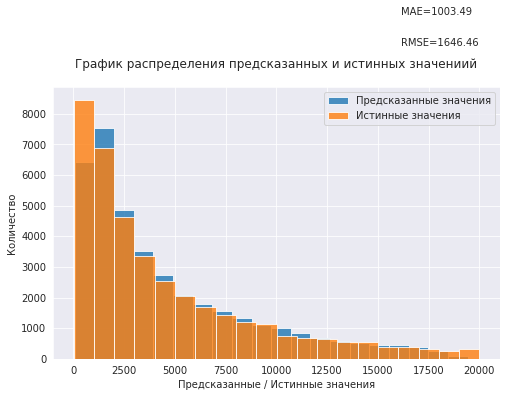

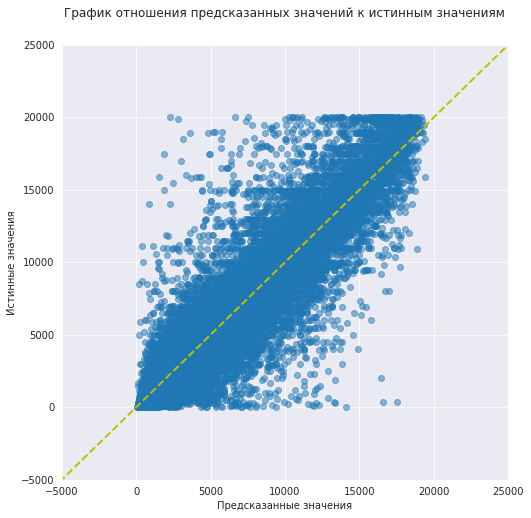

In [101]:
rmse_rf = rmse(valid_target,pred_rf)
mae_rf=mean_absolute_error(valid_target, pred_rf)
illustration_target(valid_target, pred_rf)

#### Факторы важности модели `RandomForestRegressor`

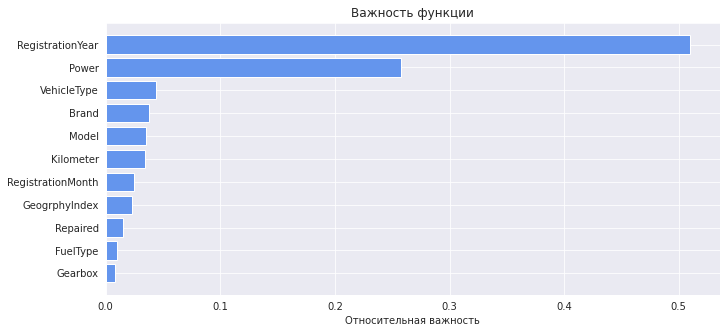

,Относительная важность
RegistrationYear,0.509998
Power,0.257790
VehicleType,0.043785
Brand,0.037911
Model,0.035514
Kilometer,0.033907
RegistrationMonth,0.024967
GeogrphyIndex,0.023147
Repaired,0.015189
FuelType,0.009459


In [102]:
importances(model_rf,valid_features)

<a id="step_2.3"></a>
### CatBoostRegressor

In [103]:
%%time
start = time.time()
model_cat = CatBoostRegressor(random_state=RANDOM_STATE,learning_rate=0.4, verbose=100,n_estimators=1000)
model_cat.fit(train_features, train_target, eval_set=(valid_features,valid_target))
end = time.time()
t_cat=round(end-start,2)

0:	learn: 3466.7863130	test: 3451.7593868	best: 3451.7593868 (0)	total: 95.9ms	remaining: 1m 35s
100:	learn: 1652.6267865	test: 1680.7969617	best: 1680.7969617 (100)	total: 3.82s	remaining: 34s
200:	learn: 1573.3351891	test: 1638.8796520	best: 1638.8796520 (200)	total: 7.7s	remaining: 30.6s
300:	learn: 1526.8261794	test: 1619.8893355	best: 1619.8893355 (300)	total: 11.8s	remaining: 27.4s
400:	learn: 1491.9034597	test: 1608.9718280	best: 1608.9349343 (399)	total: 15.6s	remaining: 23.3s
500:	learn: 1465.5404738	test: 1603.5657437	best: 1603.4613533 (477)	total: 19.2s	remaining: 19.2s
600:	learn: 1442.0945333	test: 1596.4123226	best: 1595.7128640 (594)	total: 23s	remaining: 15.3s
700:	learn: 1422.2590219	test: 1592.7325690	best: 1592.6409491 (688)	total: 26.9s	remaining: 11.5s
800:	learn: 1404.4923139	test: 1590.1283356	best: 1590.0336743 (798)	total: 30.6s	remaining: 7.6s
900:	learn: 1388.7434007	test: 1588.2548463	best: 1587.9119786 (871)	total: 34.3s	remaining: 3.77s
999:	learn: 1372.9

In [104]:
%%time
start = time.time()
predict_cat=model_cat.predict(valid_features)
end = time.time()
t_cat_p=round(end-start,2)

CPU times: user 37.8 ms, sys: 7.95 ms, total: 45.7 ms
Wall time: 43.1 ms


#### Показатели предсказания модели `CatBoostRegressor`

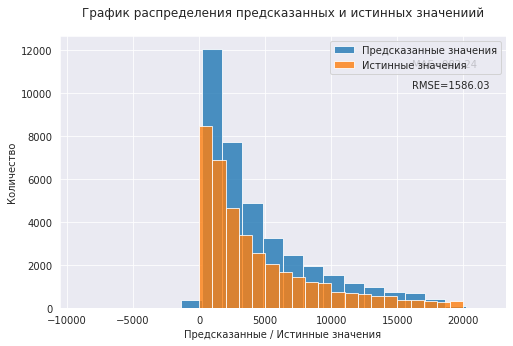

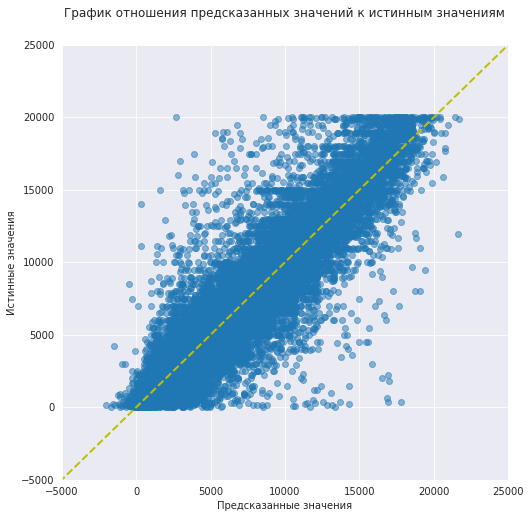

In [105]:
rmse_cat=rmse(valid_target, predict_cat)
mae_cat=mean_absolute_error(valid_target, predict_cat).round(2)
illustration_target(valid_target, predict_cat)

#### Факторы важности модели `CatBoostRegressor`

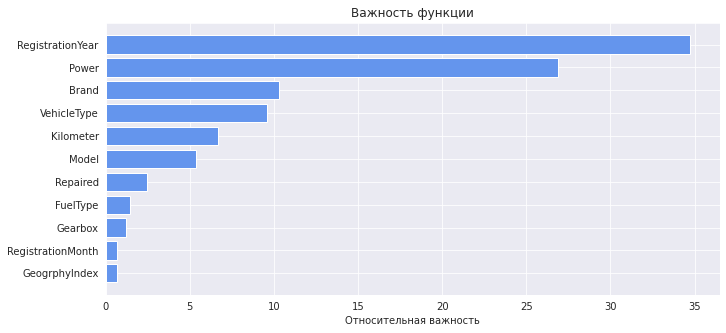

,Относительная важность
RegistrationYear,34.744928
Power,26.878990
Brand,10.325526
VehicleType,9.565567
Kilometer,6.670817
Model,5.395858
Repaired,2.448803
FuelType,1.414664
Gearbox,1.185560
RegistrationMonth,0.694381


In [106]:
importances(model_cat,train_features)

<a id="step_2.4"></a>
### LightGBM

In [107]:
# features_train_lgbm, features_eval, target_train_lgbm, target_eval = \
# train_test_split(train_features, train_target, test_size=0.05, random_state=RANDOM_STATE)

In [108]:
#   def objective(trial: optuna.trial.Trial):
#      param = {
#          'learning_rate':
#          trial.suggest_float('learning_rate', 0.1, 1),
#          'max_depth':
#          trial.suggest_int('max_depth', 5, 10)
#      } | {'random_state': RANDOM_STATE,
#           'objective': 'regression',
#           'metric': 'rmse', 
#           'feature_pre_filter' : False}
    
#      model = LGBMRegressor(**param)
#      model.fit(features_train_lgbm, target_train_lgbm,
#                eval_set=[(features_eval,
#                           target_eval)],
#                early_stopping_rounds=10,
#                verbose=True)
#      prediction = model.predict(features_valid)
#      return mean_squared_error(target_valid, prediction) ** 0.5
    
    
    
# studies = optuna.create_study(direction='minimize', study_name="LightGBM")
# studies.optimize(objective, n_trials=5)
# lgb_params = studies.best_params | {'random_state': RANDOM_STATE,
#                                           'objective': 'regression',
#                                           'metric': 'rmse'}

In [109]:
%%time
start = time.time()
model_LGB = lgbm.sklearn.LGBMRegressor(n_estimators=1000, random_state=RANDOM_STATE, learning_rate=0.4, objective='rmse')
model_LGB.fit(train_features, train_target, eval_set=(valid_features,valid_target), verbose=100)
end = time.time()
t_lgb=round(end-start,2)

[100]	valid_0's rmse: 1633.18
[200]	valid_0's rmse: 1606.14
[300]	valid_0's rmse: 1602.19
[400]	valid_0's rmse: 1596.06
[500]	valid_0's rmse: 1594.22
[800]	valid_0's rmse: 1595.44
[900]	valid_0's rmse: 1595.76
[1000]	valid_0's rmse: 1598.38
CPU times: user 9min 14s, sys: 5.13 s, total: 9min 19s
Wall time: 9min 24s


In [110]:
%%time
start = time.time()
predict_LGB= model_LGB.predict(valid_features)
end = time.time()
t_lgb_p=round(end-start,2)

CPU times: user 2.84 s, sys: 8.58 ms, total: 2.84 s
Wall time: 2.89 s


In [111]:
print(' Гиперпараметры модели:\n',model_LGB)

 Гиперпараметры модели:
 LGBMRegressor(learning_rate=0.4, n_estimators=1000, objective='rmse',
              random_state=42)


#### Показатели предсказания модели `LightGBM`

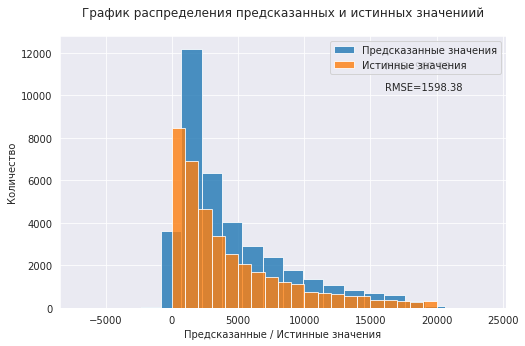

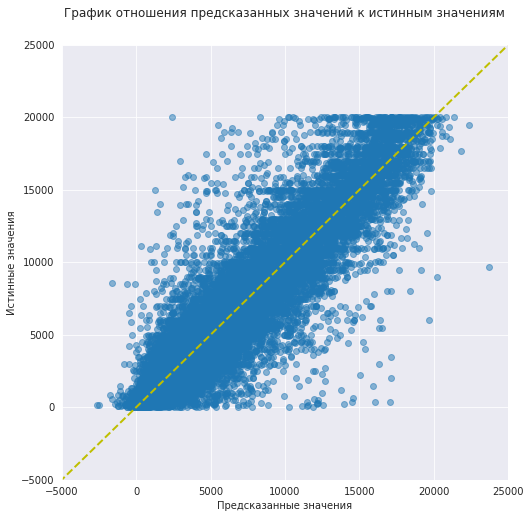

In [112]:
rmse_gbm=rmse(valid_target, predict_LGB)
mae_gbm=mean_absolute_error(valid_target, predict_LGB).round(2)
illustration_target(valid_target, predict_LGB)

#### Факторы важности модели `LightGBM`

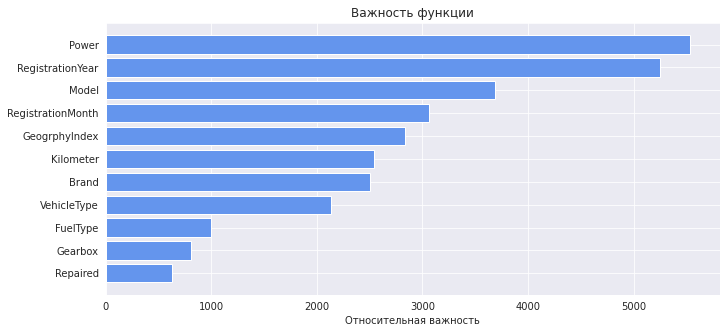

,Относительная важность
Power,5537
RegistrationYear,5252
Model,3689
RegistrationMonth,3067
GeogrphyIndex,2837
Kilometer,2537
Brand,2502
VehicleType,2138
FuelType,999
Gearbox,812


In [113]:
importances(model_LGB,train_features)

<a id="step_2.end"></a>
## Вывод

По качеству предсказания на метрике $MAE$ и распределению значений на графиках лучше всех себя показала модель `RandomForestRegressor`, в то время как модель `LightGBM` показала лучший результат по $RMSE$ и в отличии от двух других моделей важность года регистрации (*RegistrationYear*) ушла на второй план уступив мощности (*Power*), а вот модель `LinearRegression` оказаласть совсем не точной, но за то быстрее всех.

<a href='#start'>Вернуться к оглавлению</a>
<a id="step_3"></a>
## Анализ моделей





### Проанализируем скорость работы и качество моделей.

<b>Для наглядности сведём все интересующие нас даные в таблицу

In [114]:
column=['RMSE модели','MAE модели','Скорость обучения, s','Скорость предсказания, s']

comparison_tabl = pd.DataFrame(index=['RMSE модели','MAE модели','Скорость обучения, s', 'Скорость предсказания, s'], columns=['LinearRegression','RandomForestRegressor','CatBoostRegressor','LightGBM'])
comparison_tabl['LinearRegression'] = rmse_lr, mae_lr, t_lr, t_lr_p
comparison_tabl['RandomForestRegressor'] = rmse_rf, mae_rf, t_rf, t_rf_p
comparison_tabl['CatBoostRegressor'] = rmse_cat,mae_cat, t_cat, t_cat_p
comparison_tabl['LightGBM'] = rmse_gbm,mae_gbm,t_lgb,t_lgb_p

comparison_tabl.T.style.highlight_min(color='yellowgreen',subset=column).highlight_null(null_color='lightgrey').highlight_max(color='coral',subset=column)

,RMSE модели,MAE модели,"Скорость обучения, s","Скорость предсказания, s"
LinearRegression,3158.230000,2243.368315,0.110000,0.000000
RandomForestRegressor,1646.460000,1003.487171,100.820000,2.750000
CatBoostRegressor,1586.030000,982.240000,41.320000,0.040000
LightGBM,1598.380000,987.960000,564.730000,2.890000


<a id="step_3.2"></a>
### Проведём анализ остатков предсказаний моделей и определим что и как модель чаще всего хорошо/плохо предсказывает

#### Добавим в выборку категоризацию по типу возрастного класса а/м

In [115]:
features1=features.copy()

#####  Для дальнейшей фильтрации, посмотрим список присутствующих значений в нашей выборке по годам в порядке возростания

In [116]:
pd.Series(features1['RegistrationYear'].unique()).sort_values(ascending=True)

65    1950
61    1951
66    1952
63    1953
64    1954
      ... 
22    2012
26    2013
6     2014
30    2015
9     2016
Length: 67, dtype: int64

#### Добавим категории в нашу выборку в зависимсоти от года авто `ретро, суперретро, старая, новая`

In [117]:
k=[]
for i in features1['RegistrationYear']:
    if i <= 1980:
        s_old='Super Retro'
        k.append(s_old)
    if i > 1980 and i <= 2000:
        retro='Retro'
        k.append(retro)
    if i > 2000 and i <= 2012:
        old='Old'
        k.append(old)
    if i > 2012:
        new='New'
        k.append(new)
features['AgeType']=k

##### Проверяем результат

In [118]:
features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,GeogrphyIndex,AgeType
0,N/A,1993,manual,0,golf,150000,6,petrol,volkswagen,N/A,7,Retro
1,coupe,2011,manual,190,N/A,125000,5,gasoline,audi,yes,6,Old
2,suv,2004,auto,163,grand,125000,8,gasoline,jeep,N/A,9,Old
3,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,9,Old
4,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,6,Old


#### Добавим разницу значений `предсказания` - `истинные значения` в таблицу для наших моделей

In [119]:
valid_features['AgeType']=features['AgeType'][valid_features.index]

In [120]:
valid_features['Test_LGBM']=predict_LGB-valid_target
valid_features['Test_CAT']=predict_cat-valid_target
valid_features['Test_RandomForest']=pred_rf-valid_target
valid_features['Test_LinRegressor']=predict_lr-valid_target
valid_features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,GeogrphyIndex,AgeType,Test_LGBM,Test_CAT,Test_RandomForest,Test_LinRegressor
166379,0.024352,-1.117346,0.520499,-0.100745,-1.328902,0.579000,2,0.704929,-1.416748,2.046853,8,Retro,287.854577,221.828870,357.015000,938.924510
103562,0.024352,-0.675215,0.520499,0.610377,-0.992592,0.579000,11,0.704929,-0.738805,0.153575,9,Retro,-663.451430,-612.221239,-623.986667,769.006940
14899,0.024352,-0.675215,0.520499,-0.527418,0.156467,0.579000,5,0.704929,1.295022,0.153575,6,Retro,-338.058752,-266.071850,-157.722857,-488.653359
35016,0.440476,1.388066,0.520499,-0.337785,-0.305960,-2.095087,10,0.704929,0.240445,0.153575,8,Old,635.179107,468.679656,322.660000,702.386052
265147,0.024352,-0.527838,0.520499,0.025677,0.913164,0.579000,5,-1.539000,1.295022,0.153575,9,Retro,-7.785474,-3.390389,-51.550000,2570.172514


#### Составим сводную таблицу по среднему значению отклонения предсказанных от истинных значений с разбивкой на типы возраста а/м

In [122]:
analis_table=valid_features.groupby('AgeType')[['Test_LGBM','Test_CAT','Test_RandomForest','Test_LinRegressor']].mean()
analis_table.columns=['LightGBM', 'CatBoostRegressor','RandomForestRegressor','LinearRegressor']
analis_table

,LightGBM,CatBoostRegressor,RandomForestRegressor,LinearRegressor
AgeType,,,,
New,-65.406320,-56.498428,-16.412689,477.008217
Old,-9.254376,-7.205014,24.653781,-252.079715
Retro,12.452519,10.298655,52.442653,556.545948
Super Retro,170.663962,107.046891,139.692006,-7253.230981


<a id="step_3.g"></a>
#### Для наглядности отобразим отклонения на графике

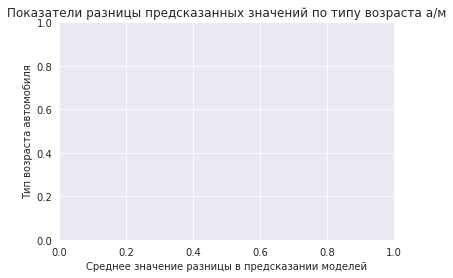

In [123]:
### Проверка лучшей модели на test выборкеanalis_table.plot(kind='barh',align='center',figsize=(14,6))
plt.title('Показатели разницы предсказанных значений по типу возраста а/м')
plt.xlabel('Среднее значение разницы в предсказании моделей')
plt.ylabel('Тип возраста автомобиля')
plt.show()

### Проверка лучшей модели на test выборке

In [ ]:
%%time
start = time.time()
pred_rf=model_rf.predict(test_features)
end = time.time()
t_rf_p=round(end-start,2)

In [ ]:
rmse_rf = rmse(test_target,pred_rf)
mae_rf=mean_absolute_error(test_target, pred_rf)
illustration_target(test_target, pred_rf)

In [ ]:
importances(model_rf,test_features)

<a id="step_3.3"></a>
### Вывод

По результату анализа остатков предсказания моделей, на графике хорошо видно сильное отрицательное отклонение в предсказании данных при помощи `LinearRegressor` в возростной группе автомобилей **SuperRetro**. По другим моделям наблюдается некоторый паритет по обработке возрастных категорий. Тем не менее в группе **SuperRetro**, модели использующие градиентный спуск так же чаще ошибаются в предсказаниях.

<a href='#start'>Вернуться к оглавлению</a>
<a id="step_3.end"></a>
## Общий вывод

   Перед нами стояла задача- построить модель для определения стоимости автомобиля, с лушими показателями качества предсказания, скорости и врмени обучения. В нашем распоряжении были исторические данные: технические характеристики, комплектации и цены автомобилей.<br>
   
   Мы использовали технологию градиетного бустинга в моделях `CatBoostRegressor` и `LightGBM`, и сравнили её с базовыми моделями `LinearRegression` и `RandomForestRegressor`<br>
   
   По итогам качества и скорости обучения на тестовых данных - с небольшим отрывом от `CatBoostRegressor` побеждает модель `LightGBM`, но сильно уступает по скорости предсказания.<br> 
   
   Таким образом для компании "**Не бит, не крашен**" можем смело рекомендовать модель **`CatBoostRegressor`**, т.к. можно немного поступиться со скоростью обучения в пользу достижения скорости работы на новых данных при сохранении приблизительно тех же показателей по качеству предсказания<br> 

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей